## Few imports

In [15]:
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from tqdm import tqdm
from nilearn import plotting
from nibabel import processing
from joblib import Parallel, delayed
import sklearn

# Set-up root and read demography

In [2]:
rootDir = '../../../gitProjects/brainage'
df = pd.read_excel(f'{rootDir}/IXI.xls')
df.dropna(inplace=True)
df.drop_duplicates(subset='IXI_ID',keep='last', inplace=True)
print(f'dataset is of shape: {df.shape}')
df.drop(columns=['HEIGHT','WEIGHT','ETHNIC_ID','MARITAL_ID','OCCUPATION_ID','QUALIFICATION_ID','DOB','DATE_AVAILABLE','STUDY_DATE'],
        axis=1, inplace=True)
df.head()

dataset is of shape: (565, 12)


,IXI_ID,"SEX_ID (1=m, 2=f)",AGE
1,2,2,35.800137
2,12,1,38.781656
3,13,1,46.710472
4,14,2,34.236824
5,15,1,24.284736


# Load MRI data and reslice to reduce memory 

In [3]:
images = []
id = []
for ids in df['IXI_ID']:
    try:
        image = nib.load(f'{rootDir}/mwp1/mwp1IXI{str(ids).zfill(3)}_T1.nii')
        images.append(image)
        id.append(ids)
    except FileNotFoundError:
        print(f'File not found for IXI_ID: {ids}')
reslice = [processing.resample_to_output(image, voxel_sizes=(2,2,2)) for image in tqdm(images)]


File not found for IXI_ID: 116
File not found for IXI_ID: 182
File not found for IXI_ID: 309
File not found for IXI_ID: 500
File not found for IXI_ID: 580
File not found for IXI_ID: 628


100%|██████████| 559/559 [05:55<00:00,  1.57it/s]


Apply FWHM = 4mm

In [4]:
# if there are multiple cores available
# smoothed_images = Parallel(n_jobs=-1)(
#     delayed(processing.smooth_image)(reslice_image, fwhm=4.0)
#     for reslice_image in reslice
# )
smooth = [processing.smooth_image(reslice_image, fwhm=4) for reslice_image in tqdm(reslice)]

100%|██████████| 559/559 [00:18<00:00, 29.97it/s]


Plot one image to see what it looks like

Text(0.5, 1.0, 'gray matter segmentation of T1w-MRI image')

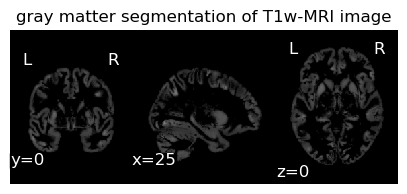

In [5]:
fig, ax = plt.subplots(figsize=(5,2))
plotting.plot_anat(images[0], axes=ax, draw_cross=False)
ax.set_title('gray matter segmentation of T1w-MRI image')

In [7]:
921*109*91

9135399

Apply PCA on the feature set with 10-20 components. Otherwise, the feature set will be of size 9135399 (or) ~9Million. This is also the reason, why we reslice the image.

In [12]:
# flatten the images
features = [np.array(smooth[i].get_fdata()).flatten() for i in tqdm(range(0,len(smooth)))]


100%|██████████| 559/559 [00:28<00:00, 19.84it/s]


In [19]:
pca = sklearn.decomposition.PCA(n_components = 20)
modelFit = pca.fit(features)
results = modelFit

: 

: 